In [ ]:
# --- Imports ---
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

from auction import Auction
from player import RangePlayer

# Ensure plots render inline
%matplotlib inline

In [ ]:
# --- Simulation Configuration ---

EPSILON = 0.00001

slow_speed = (0.0, 0.4)
slow_mean = 0.8
fast_mean = 0.4  # fixed to isolate speed effect

starts = np.linspace(0, 0.7, 100)
fast_speed_ranges = [(round(start, 3), round(start + 0.3, 3)) for start in starts]

num_slow = 1
num_fast = 1
num_rounds = 216000
bid_range_width = 0.2
cutoff_time_range = (0.6, 0.7 - EPSILON)
sealed_bids = False

In [ ]:
# --- Run Simulations ---

def safe_divide(a, b):
    return a / (b + 1e-9)

def compute_profits(player_ids, profits, submit_bys, cutoff_time, winner):
    for pid in player_ids:
        if submit_bys[pid] < cutoff_time:
            if winner and pid == winner[0]:
                profits.append(winner[2])
            else:
                profits.append(0.0)

results = []

for fast_speed in tqdm(fast_speed_ranges, desc="Running Simulations"):
    players = []
    player_id_offset = len(results) * (num_slow + num_fast)

    # Create slow (non-reactive) players
    for i in range(num_slow):
        lo = random.uniform(*slow_speed)
        hi = random.uniform(*slow_speed)
        speed = (min(lo, hi), max(lo, hi))

        bid_range = (
            slow_mean,
            bid_range_width
        )
        players.append(RangePlayer(player_id_offset + i, speed, bid_range, reactive=False))

    # Create fast (reactive) players
    for i in range(num_fast):
        lo = random.uniform(*fast_speed)
        hi = random.uniform(*fast_speed)
        speed = (min(lo, hi), max(lo, hi))
        bid_range = (
            fast_mean,
            bid_range_width
        )
        players.append(RangePlayer(player_id_offset + num_slow + i, speed, bid_range, reactive=True))

    auction = Auction(players, cutoff_time_range, sealed_bids)
    round_results, winnings = auction.run_simulation(num_rounds)

    fast_ids = [p.player_id for p in players if p.reactive]
    slow_ids = [p.player_id for p in players if not p.reactive]

    fast_profits = []
    slow_profits = []

    for r in round_results:
        cutoff_time = r["cutoff_time"]
        submit_bys = r["submit_bys"]
        winner = r["winner"]

        compute_profits(fast_ids, fast_profits, submit_bys, cutoff_time, winner)
        compute_profits(slow_ids, slow_profits, submit_bys, cutoff_time, winner)


    fast_wins = sum(1 for r in round_results
                    if r['winner'] and r['winner'][0] in fast_ids and
                    r["submit_bys"][r['winner'][0]] < r["cutoff_time"])

    slow_wins = sum(1 for r in round_results
                    if r['winner'] and r['winner'][0] in slow_ids and
                    r["submit_bys"][r['winner'][0]] < r["cutoff_time"])


    total_fast_bids = total_fast_missed = total_slow_bids = total_slow_missed = 0
    for r in round_results:
        cutoff = r["cutoff_time"]
        submit_bys = r["submit_bys"]
        for pid in fast_ids:
            if submit_bys[pid] >= cutoff:
                total_fast_missed += 1
            total_fast_bids += 1
        for pid in slow_ids:
            if submit_bys[pid] >= cutoff:
                total_slow_missed += 1
            total_slow_bids += 1

    fast_valid_bids = total_fast_bids - total_fast_missed
    slow_valid_bids = total_slow_bids - total_slow_missed

    results.append({
        "fast_speed_range": fast_speed,
        "fast_max_speed": fast_speed[1],
        "slow_total_profit": round(sum(slow_profits) / num_slow, 5),
        "slow_win_rate": round(slow_wins / (num_slow * num_rounds), 5),
        "fast_total_profit": round(sum(fast_profits) / num_fast, 5),
        "fast_win_rate": round(fast_wins / (num_fast * num_rounds), 5),
        "fast_miss_rate": round(total_fast_missed / total_fast_bids, 5),
        "slow_miss_rate": round(total_slow_missed / total_slow_bids, 5),
        "fast_avg_profit_per_bid": round(safe_divide(sum(fast_profits), fast_valid_bids), 5),
        "slow_avg_profit_per_bid": round(safe_divide(sum(slow_profits), slow_valid_bids), 5),
        "fast_avg_profit_per_win": round(safe_divide(sum(fast_profits), fast_wins), 5),
        "slow_avg_profit_per_win": round(safe_divide(sum(slow_profits), slow_wins), 5)
    })

df = pd.DataFrame(results)
df["fast_speed_range"] = df["fast_speed_range"].astype(str)
df.to_csv("speed_grid__speeds_results.csv", index=False)
df.head()

,fast_speed_range,fast_max_speed,slow_total_profit,slow_win_rate,fast_total_profit,fast_win_rate,fast_miss_rate,slow_miss_rate,fast_avg_profit_per_bid,slow_avg_profit_per_bid,fast_avg_profit_per_win,slow_avg_profit_per_win
0,"(np.float64(0.0), np.float64(0.3))",0.300,17254.31503,0.66637,19573.30781,0.33363,0.0,0.0,0.09062,0.07988,0.27161,0.11987
1,"(np.float64(0.007), np.float64(0.307))",0.307,11035.19199,0.42029,35871.97778,0.57971,0.0,0.0,0.16607,0.05109,0.28648,0.12156
2,"(np.float64(0.014), np.float64(0.314))",0.314,11267.56915,0.42725,35410.96360,0.57275,0.0,0.0,0.16394,0.05216,0.28623,0.12209
3,"(np.float64(0.021), np.float64(0.321))",0.321,10581.76280,0.40144,37056.55636,0.59856,0.0,0.0,0.17156,0.04899,0.28662,0.12203
4,"(np.float64(0.028), np.float64(0.328))",0.328,10551.54310,0.40170,37102.61819,0.59830,0.0,0.0,0.17177,0.04885,0.28710,0.12161


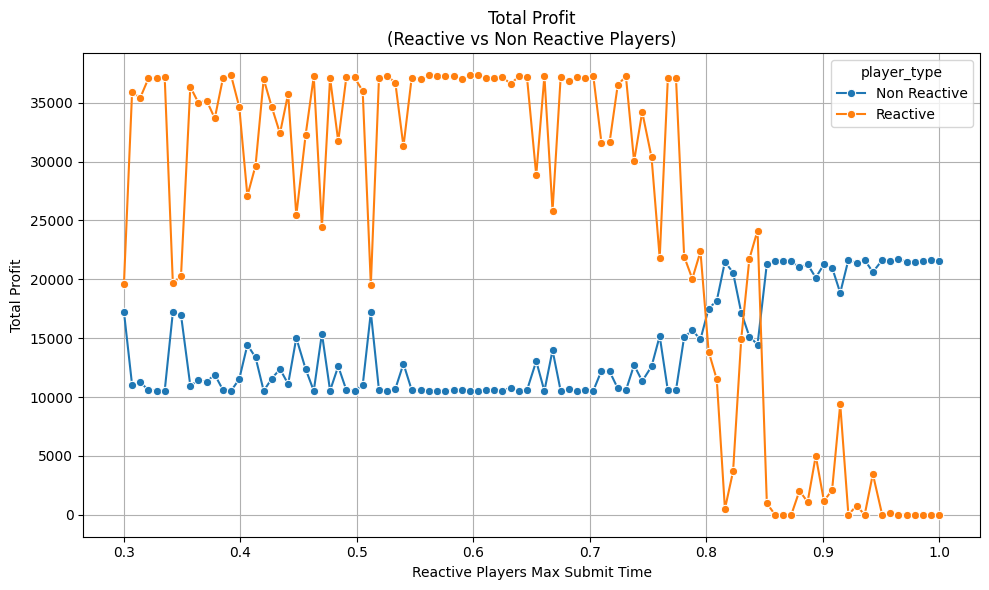

In [11]:
TOTAL_VALUE = 216000  

melted = pd.melt(
    df,
    id_vars=["fast_max_speed"],
    value_vars=["slow_total_profit", "fast_total_profit"],
    var_name="player_type",
    value_name="total_profit"
)

melted["player_type"] = melted["player_type"].map({
    "slow_total_profit": "Non Reactive",
    "fast_total_profit": "Reactive"
})

profit_df = (
    melted.groupby(["fast_max_speed", "player_type"])
    .agg(total_profit=("total_profit", "sum"))
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=profit_df, x="fast_max_speed", y="total_profit", hue="player_type", marker="o")
plt.title("Total Profit\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Total Profit")
plt.grid(True)
plt.tight_layout()
plt.show()

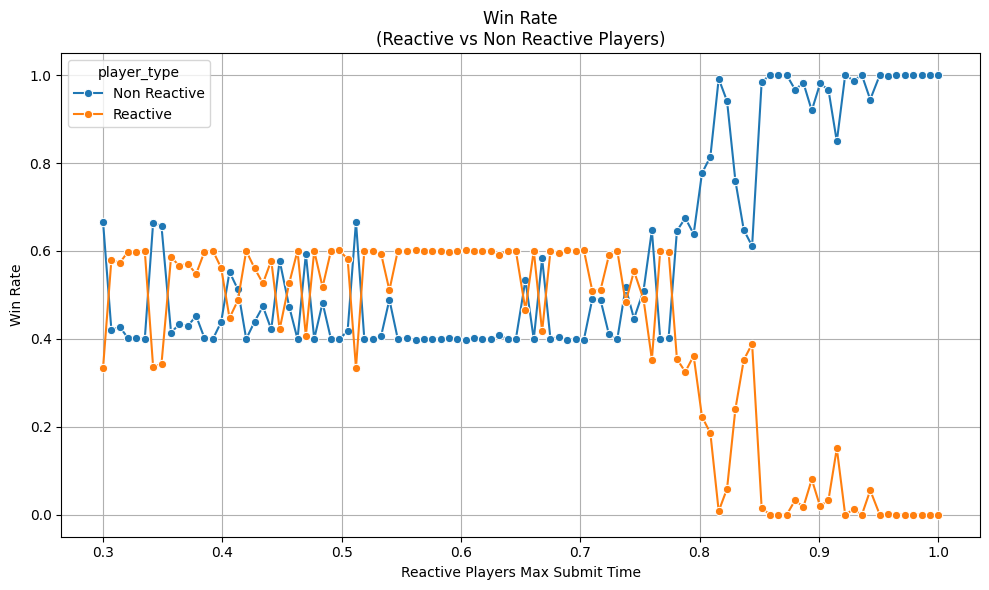

In [12]:
winrate_df = pd.concat([
    df[["fast_max_speed", "slow_win_rate"]].rename(columns={"slow_win_rate": "win_rate"}).assign(player_type="Non Reactive"),
    df[["fast_max_speed", "fast_win_rate"]].rename(columns={"fast_win_rate": "win_rate"}).assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=winrate_df, x="fast_max_speed", y="win_rate", hue="player_type", marker="o")
plt.title("Win Rate\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Win Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("winrate_comparison_by_speed.png")
plt.show()

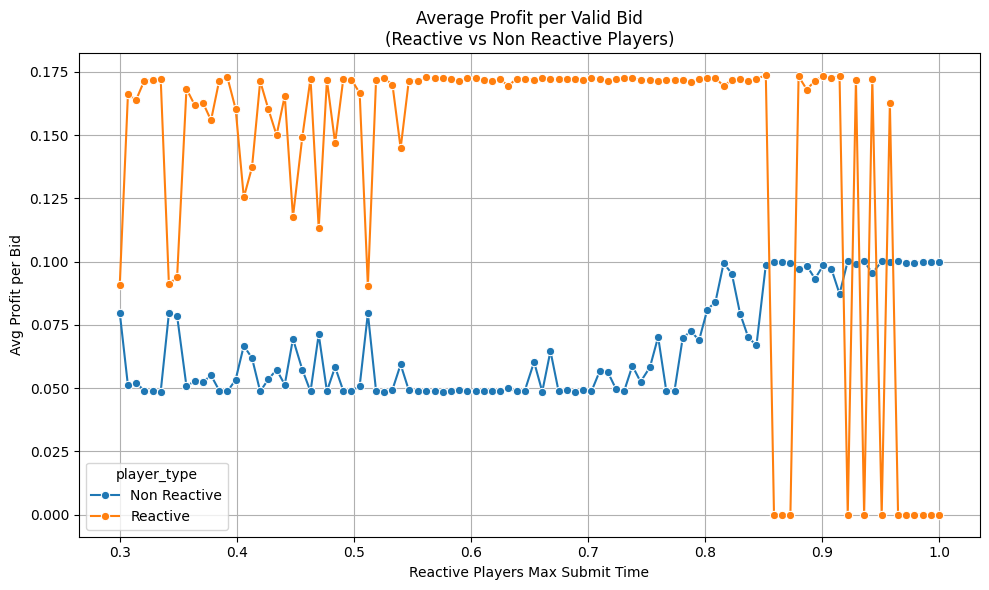

In [13]:
avg_bid_profit_df = pd.concat([
    df[["fast_max_speed", "slow_avg_profit_per_bid"]]
      .rename(columns={"slow_avg_profit_per_bid": "avg_profit_per_bid"})
      .assign(player_type="Non Reactive"),
    
    df[["fast_max_speed", "fast_avg_profit_per_bid"]]
      .rename(columns={"fast_avg_profit_per_bid": "avg_profit_per_bid"})
      .assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_bid_profit_df, x="fast_max_speed", y="avg_profit_per_bid", hue="player_type", marker="o")
plt.title("Average Profit per Valid Bid\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Avg Profit per Bid")
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_profit_per_bid_by_speed.png")
plt.show()

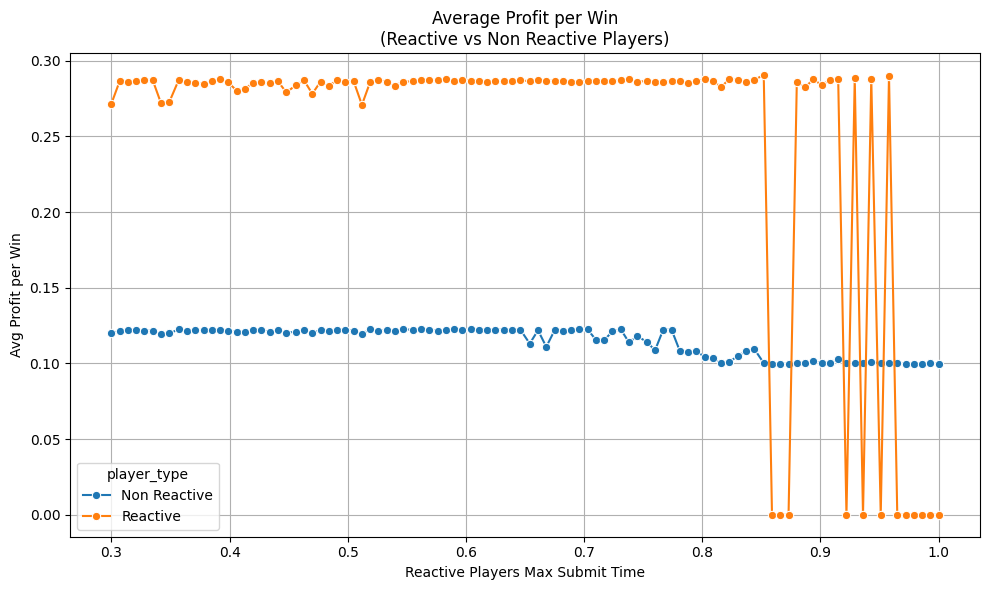

In [14]:
avg_win_profit_df = pd.concat([
    df[["fast_max_speed", "slow_avg_profit_per_win"]]
      .rename(columns={"slow_avg_profit_per_win": "avg_profit_per_win"})
      .assign(player_type="Non Reactive"),
    
    df[["fast_max_speed", "fast_avg_profit_per_win"]]
      .rename(columns={"fast_avg_profit_per_win": "avg_profit_per_win"})
      .assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_win_profit_df, x="fast_max_speed", y="avg_profit_per_win", hue="player_type", marker="o")
plt.title("Average Profit per Win\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Avg Profit per Win")
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_profit_per_win_by_speed.png")
plt.show()